### Proje Başlığı: “İşe Alımda Aday Seçimi: SVM ile Başvuru Değerlendirme”

Senaryo: Bir teknoloji firmasında insan kaynakları ekibindesiniz. Amacınız, yazılım geliştirici pozisyonu için başvuran adayların tecrübe yılı ve teknik sınav puanına göre işe alınıp alınmamasını tahmin eden bir model geliştirmek.

Veri Özellikleri: Her başvuru için şu bilgiler vardır:

- tecrube_yili: Adayın toplam yazılım deneyimi (0–10 yıl arası)

- teknik_puan: Teknik sınavdan alınan puan (0–100 arası)

- etiket:

    - 1: İşe alınmadı (başarısız aday)

    - 0: İşe alındı (başarılı aday)

- Etiketleme Kriteri (kural tabanlı):

->> Tecrübesi 2 yıldan az ve sınav puanı 60’tan düşük olanlar işe alınmıyor.


**Görevler:**
1. Faker ya da random ile en az 200 başvuru verisi üret.

2. Tecrübe ve teknik puana göre yukarıdaki kuralla etiketle.

3. Veriyi eğitim ve test olarak ayır.

4. Veriyi StandardScaler ile ölçekle.

5. SVC(kernel='linear') ile modeli eğit.

6. Karar sınırını matplotlib ile görselleştir.

7. Kullanıcıdan tecrübe ve teknik puan alarak tahmin yap.

8. accuracy_score, confusion_matrix, classification_report ile başarıyı değerlendir.


**Gelişim Alanları:**
- Kernel değiştirerek doğrusal olmayan sınıfları da deneme

- Modeli FastAPI ile servise dönüştürme

- Parametre tuning (C, gamma) (AR-GE)

->> *Bonus : Faker kütüphanesini araştırınız*

### 1. Veri Üretimi
🎯 **Hedef:** En az 200 başvuru için tecrube_yili (0–10 yıl) ve teknik_puan (0–100 arası) değerlerine sahip veriler üretmek.

🔧 **Araç Seçimi:** random veya Faker

✅ Seçilen Yöntem: **Python random kütüphanesi**
random.uniform() ile süreklilik gösteren sayılar (float) üretmek daha doğrudur çünkü gerçek hayatta hem tecrübe hem puan tam sayılardan oluşmaz.

->> Faker daha çok isim, adres gibi metin bazlı veriler üretmek için optimize edilmiştir. Sayısal veri üretiminde random daha yalın ve kontrol edilebilirdir.

❌ Bu nedenle tecrübe ve teknik puan gibi sayısal veriler için özelleşmiş olmayan ve daha çok demografik ya da metinsel veri üretiminde avantajlı olan **Faker** kütüphanesi tercih edilmemiştir.

In [2]:
import random
import pandas as pd

random.seed(42)

In [30]:
veri = []
for _ in range(200):
    tecrube = round(random.uniform(0, 10), 2)
    teknik_puan = round(random.uniform(0, 100), 2)
    # Etiketleme kuralı: Tecrübe < 2 ve puan < 60 ise alınmaz (1)
    etiket = 1 if tecrube < 2 and teknik_puan < 60 else 0
    veri.append([tecrube, teknik_puan, etiket])

In [31]:
df = pd.DataFrame(veri, columns=["tecrube_yili", "teknik_puan", "etiket"])

In [32]:
df

,tecrube_yili,teknik_puan,etiket
0,2.83,29.86,0
1,5.87,99.89,0
2,4.90,14.86,0
3,5.39,34.51,0
4,5.52,54.34,0
...,...,...,...
195,7.09,41.77,0
196,1.15,2.09,1
197,3.25,80.13,0
198,6.18,83.20,0


In [33]:
print(" İşe alınmaz -> 1 numaralı etiketler: ",df[df['etiket'] == 1].shape[0])
print(" İşe alınır -> 0 numaralı etiketler: ",df[df['etiket'] == 0].shape[0])

 İşe alınmaz -> 1 numaralı etiketler:  21
 İşe alınır -> 0 numaralı etiketler:  179


### 2. Veri Setinin Eğitim/Test Olarak Ayrılması
🎯 **Hedef:** Modelin öğrenme ve genelleme başarısını ölçmek için veriyi ikiye ayırmak.

🔧 **Araç Seçimi:** train_test_split (sklearn)

✅ Neden: train_test_split veri setini rastgele ama kontrol edilebilir şekilde bölmektedir.

NOT: Stratified bölme ihtiyacı yoktur; çünkü veri dengesiz değildir (etiket dağılımı dengeli üretildiği varsayılarak).

In [34]:
from sklearn.model_selection import train_test_split

In [35]:
X = df[["tecrube_yili", "teknik_puan"]]
y = df["etiket"]

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 3. Veri Ölçekleme
🎯 **Hedef:** SVM, özellikle mesafe temelli bir algoritma olduğundan farklı ölçeklerdeki verilerden etkilenir. Bu yüzden standartlaştırma yapılmalıdır.

🔧 **Araç Seçimi:** StandardScaler

✅ Neden: Ortalama 0, standart sapma 1 olacak şekilde verileri dönüştürmektedir. Özellikle doğrusal SVM gibi mesafeye duyarlı algoritmalarda gereklidir.

❌ MinMaxScaler elenmez; SVM için **MinMaxScaler** da kullanılabilir, ancak **StandardScaler** genellikle daha istikrarlı sonuç verir.

In [37]:
from sklearn.preprocessing import StandardScaler

In [38]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 4. Model Eğitimi
🎯 **Hedef:** Verilen iki özelliğe göre (tecrübe & teknik puan) doğrusal bir sınıflayıcı oluşturmak.

🔧 **Model: SVC(kernel='linear')**

In [39]:
from sklearn.svm import SVC

In [40]:
model = SVC(kernel='linear')
model.fit(X_train_scaled, y_train)

SVC(kernel='linear')

### 5. Karar Sınırının Görselleştirilmesi
🎯 **Hedef:** Modelin tecrübe ve teknik puan düzlemi üzerinde nasıl bir karar sınırı çizdiğini gözlemlemek.

🔧 **Araç Seçimi:** matplotlib + numpy meshgrid

In [41]:
import matplotlib.pyplot as plt
import numpy as np

x_min, x_max = X_train_scaled[:, 0].min() - 1, X_train_scaled[:, 0].max() + 1
y_min, y_max = X_train_scaled[:, 1].min() - 1, X_train_scaled[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

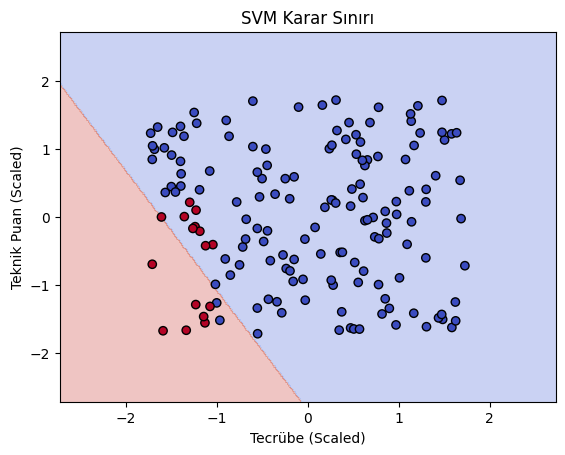

In [42]:
# Görselleştirme : 
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
plt.scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], c=y_train, cmap=plt.cm.coolwarm, edgecolors='k')
plt.xlabel("Tecrübe (Scaled)")
plt.ylabel("Teknik Puan (Scaled)")
plt.title("SVM Karar Sınırı")
plt.show()

### 6. Kullanıcıdan Girdi Alarak Tahmin
🎯 **Hedef:** Modelin gerçek hayatta nasıl çalışacağını simüle etmek.

🔧 **Yaklaşım:** Kullanıcıdan alınan tecrübe yılı ve teknik puan ölçeklenmeli.

In [44]:
# Kullanıcıdan veri alma ve tahmin sonucu verme : 

tecrube_input = float(input("Tecrübe yılı (0-10): "))
puan_input = float(input("Teknik sınav puanı (0-100): "))

veri_input = scaler.transform([[tecrube_input, puan_input]])
tahmin = model.predict(veri_input)[0]

if tahmin == 0:
    print("✅ Aday işe alınır.")
else:
    print("❌ Aday reddedilir.")

Tecrübe yılı (0-10):  2
Teknik sınav puanı (0-100):  75


✅ Aday işe alınır.


/Users/elifdy/VScode/myPython.v1/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


### 7. Modelin Performans Değerlendirmesi
🎯 **Hedef:** Modelin ne kadar iyi sınıflandırma yaptığına dair metrikleri görmek.

🔧 **Araçlar:** accuracy_score, confusion_matrix, classification_report

In [15]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y_pred = model.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.975

Confusion Matrix:
 [[35  0]
 [ 1  4]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99        35
           1       1.00      0.80      0.89         5

    accuracy                           0.97        40
   macro avg       0.99      0.90      0.94        40
weighted avg       0.98      0.97      0.97        40



Sonuçların değerlendirilmesi : 

- **Confusion Matrix:** 
    - 0 (işe alındı) sınıfı için 35 doğru tahmin, 0 yanlış.
    - 1 (işe alınmadı) sınıfı için 4 doğru, 1 yanlış tahmin.
- **Precision / Recall / F1:***
    - 0 (alındı): precision=0.97, recall=1.00, f1=0.99
    - 1 (alınmadı): precision=1.00, recall=0.80, f1=0.89
      
->> Recall (1. sınıf için): Sadece %80. Bu sonuçlara göre bazı gerçekten alınmaması gereken adayları model işe alıyor gibi tahmin etmiştir.

## ARGE 

In [45]:
# 1. Parametre Tuning (GridSearchCV ile)
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

grid = GridSearchCV(SVC(), param_grid, refit=True, cv=5)
grid.fit(X_train_scaled, y_train)

print("En iyi parametreler:", grid.best_params_)
y_pred = grid.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

En iyi parametreler: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       1.00      1.00      1.00         5

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



In [46]:
# 2. Kernel 'rbf' ile Model Eğitimi ve Karşılaştırma

model_rbf = SVC(kernel='rbf', C=1, gamma='scale')
model_rbf.fit(X_train_scaled, y_train)

y_pred_rbf = model_rbf.predict(X_test_scaled)
print(classification_report(y_test, y_pred_rbf))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       1.00      1.00      1.00         5

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



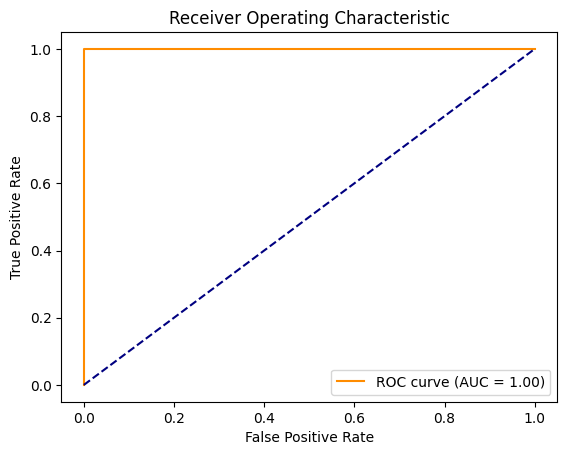

In [47]:
# 3. ROC Curve ile Sınıf Ayrımı Analizi

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_score = model.decision_function(X_test_scaled)
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.show()